# Oceanography ML Regression Project

**The goal -  predicting ocean temperature from thermodynamic and chemical measurement data.**

## initializing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

# all altair plots were saved and uploaded as images to lighten the notebook.

while True:
    try:
        import altair as alt
        break
    except ModuleNotFoundError:
        !pip install altair

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
def rmse(y, y_pred):
    return np.sqrt(mse(y, y_pred))

### defs

#### modeling

In [3]:
def fill_nulls_naively(data):
    '''
    fills nulls with each column's mean (if numerical) or mode (if categorical).
    '''
    naive_df = data.copy()
    nully_cols = naive_df.columns[naive_df.isnull().sum().astype(bool)]
    
    for col in nully_cols:
        print('filling', col)
        if naive_df[col].dtype.name.__contains__('float'):
            naive_df[col].fillna(naive_df[col].mean(), inplace=True)
        else:
            naive_df[col].fillna(naive_df[col].mode(), inplace=True)

    return naive_df

In [4]:
def split_data(data, target='temp', seeded=True, tst_pct=.3):
    
    '''
    splits data into features(X) and target(y),
    then splits both into test and train.
    '''
    X = fill_nulls_naively(data.drop(columns=target))
    y = data[target]
    
    seed = (np.random.randint(1e9), 60221023)[seeded]

    split = train_test_split(X, y, test_size=tst_pct, random_state=seed)

    return split

In [5]:
def plant_forest(features, target, seeded=True, num_of_trees=10, smp_per_tree=.25):
    '''
    trains a random forest regression model
    '''
    seed = (np.random.randint(1e9), 60221023)[seeded]
        
    model = RandomForestRegressor(
        n_estimators=num_of_trees,
        max_samples=smp_per_tree,
        random_state=seed,
        max_features='sqrt',
        n_jobs=-1
    ).fit(features, target)

    return model

#### visualizing

In [6]:
def plot_histogram(data, col, ret_stdev=False):
    '''
    as simple as that.
    '''
    
    
    stdev = data[col].std()
    hist = alt.Chart(
        data, title = ('', f'{col} stdev: {stdev:.4f}')[ret_stdev]
    ).mark_rect(
        opacity=.7, color='aquamarine', stroke='mediumaquamarine'
    ).encode(
        x=alt.X(f'{col}:Q', bin=alt.Bin(maxbins=50), title=''),
        y=alt.Y('count()', title=''),
    )

    avg = alt.Chart(data).mark_rule().encode(
        x=alt.X(f'mean({col}):Q', title=''),
        color=alt.value('navy'),
        size=alt.value(2)
    )

    plot = hist+avg

    if ret_stdev:
        return plot, stdev

    return plot

In [7]:
def plot_corr_heatmap(data):
    '''
    takes a dataframe with ordinal values,
    creates a correlation dataframe,
    and plots that as a heatmap without repeating cells.
    '''

    corr = data.drop(columns='cruise').corr().reset_index().melt(id_vars='index')
    sort = dict(zip(data.columns, list(range(len(data.columns)))))

    heatmap = alt.Chart(corr).mark_rect(
        stroke='black'
    ).transform_calculate(
        order_rows='%s [datum.index]' % sort,
        order_cols='%s [datum.variable]' % sort
    ).transform_filter(
        alt.datum.order_rows <= alt.datum.order_cols
    ).encode(
        alt.X('index:N', title=None, sort=list(sort.keys())),
        alt.Y('variable:N', title=None, sort=list(sort.keys())),
        alt.Color('value:Q', scale=alt.Scale(
            scheme='redyellowblue', reverse=True))
    ).properties(width=600, height=600)

    text = heatmap.mark_text(
        size=13
    ).encode(
        alt.Text('value:Q', format='.2f'),
        color=alt.value('white')
    )

    return heatmap + text

In [8]:
def plot_forest_results(model, Xtr, Xts, ytr, yts):
    '''
    calculates a random forest's result metrics,
    creates a scatter plot with a trendline on top,
    along with a top 10 feature importance hbar chart.
    note the sea-themed colors!
    '''

    yts_pred = model.predict(Xts)
    test_rmse = rmse(yts, yts_pred)

    ytr_pred = model.predict(Xtr)
    valid = rmse(ytr, ytr_pred)/test_rmse

    scatter = alt.Chart(
        pd.DataFrame(data={'test': yts, 'pred': yts_pred}),
        title=f'RMSE={test_rmse:.4f}     validation={valid:.1%}'
    ).mark_point(strokeWidth=1, opacity=0.5
                 ).encode(x='test:Q', y='pred:Q',
                          color=alt.value('lightseagreen')
                          ).properties(height=400, width=400)

    trendline = alt.Chart(
        pd.DataFrame({'test': [0, 35], 'pred': [0, 35]})
    ).mark_line(strokeDash=[10, 3], strokeWidth=1.5
                ).encode(x='test:Q', y='pred:Q',
                         color=alt.value('navy'))

    feature_importances = alt.Chart(
        pd.DataFrame({'feature': model.feature_names_in_,
                     'importance': model.feature_importances_}
                     ).sort_values('importance').tail(10)
    ).mark_bar(color='lightseagreen'
               ).encode(
        y=alt.Y('feature:N', sort='-x'),
        x=alt.X('importance:Q', axis=alt.Axis(format='.0%'))
    ).properties(height=150, width=400)

    model_plot = scatter+trendline & feature_importances

    return model_plot

### data

#### upload

In [9]:
upload = pd.read_csv('/'.join(['https:/',
                               'raw.githubusercontent.com',
                               'Morshay',
                               'hot-cali-oceans',
                               'master',
                               'data',
                               'clean_data.csv']))

In [10]:
init_df = upload.copy()

#### small exploration

In [11]:
print('percentage of nulls in target col:', end=' ')
print(f'{upload.sva.isnull().sum()/len(upload):.1%}')

percentage of nulls in target col: 6.1%


barely any nulls, so no need to keep them.

In [12]:
init_df.dropna(subset=['temp'], inplace=True)

In [13]:
print(init_df.info())
init_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853900 entries, 0 to 864862
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   temp      853900 non-null  float64
 1   pot_temp  818816 non-null  float64
 2   sva       812092 non-null  float64
 3   o2        691287 non-null  float64
 4   o2_molal  661268 non-null  float64
 5   o2_sat    664030 non-null  float64
 6   depth     853900 non-null  float64
 7   pres      853900 non-null  int64  
 8   dyn_ht    814636 non-null  float64
 9   pot_dens  812007 non-null  float64
 10  sal       814247 non-null  float64
 11  cruise    853900 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 84.7 MB
None


,temp,pot_temp,sva,o2,o2_molal,o2_sat,depth,pres,dyn_ht,pot_dens,sal,cruise
527186,7.89,7.86,145.0,1.63,70.90801,24.5,250.0,252,0.460,26.620,34.146,21348
96892,9.24,NaN,NaN,3.69,NaN,NaN,150.0,151,NaN,NaN,NaN,3252
43928,6.68,6.64,119.9,0.68,29.57311,9.9,400.0,403,0.710,26.900,34.288,1416
850089,17.77,17.77,392.6,5.50,240.01000,101.1,2.0,2,0.008,23.974,33.229,33828
758991,18.37,18.36,434.8,5.44,237.36150,100.8,42.0,42,0.180,23.540,32.860,30391
78546,5.02,NaN,NaN,0.44,NaN,NaN,723.0,730,NaN,NaN,NaN,2620
519374,7.15,7.13,146.9,3.22,140.07990,47.4,221.0,222,0.500,26.590,33.975,21073
34632,5.60,5.57,123.6,1.10,47.84118,15.6,400.0,403,0.730,26.850,34.051,1121
589761,8.90,8.89,169.7,2.47,107.47910,37.9,120.0,121,0.260,26.340,33.984,24074
46954,7.35,NaN,NaN,0.81,NaN,NaN,400.0,403,NaN,NaN,NaN,1515


In [14]:
temp_hist, benchmark_stdev = plot_histogram(init_df, 'temp', True)
#temp_hist

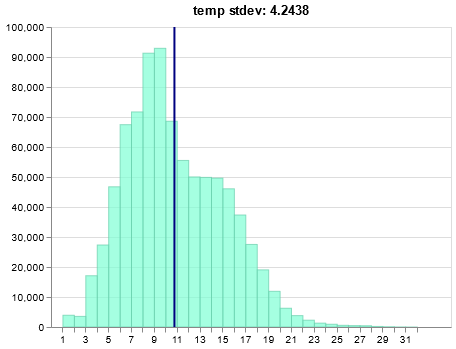

#### quick test

In [15]:
def quick_test(data, col='temp'):
    
    try:
        data = data.drop(columns='cruise') # it's just an identifier we use later on
    except KeyError:
        pass
    
    X_train, X_test, y_train, y_test = split_data(data, col)
    
    print('\nplanting a forest...')
    m = plant_forest(X_train, y_train)
    
    print(f'\nbenchmark stdev: {benchmark_stdev:.4f}')
    res_plot = plot_forest_results(m, X_train, X_test, y_train, y_test)
    
    return res_plot

In [16]:
# quick_test(init_df)

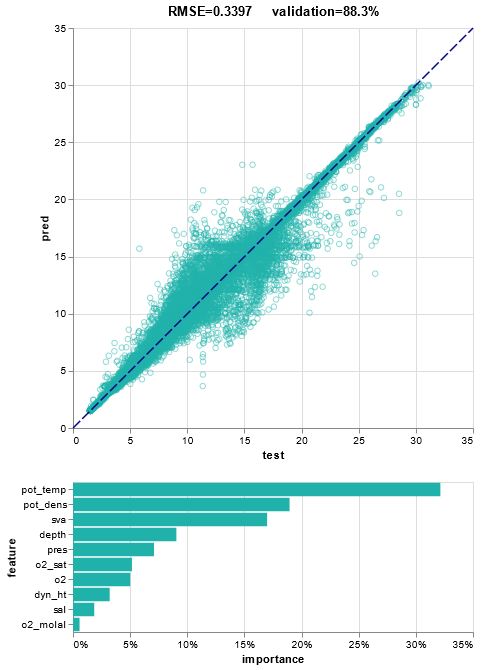

In [17]:
df = init_df.copy()

## feature engineering

### feature selection

In [18]:
ft_slc_df = df.copy()

In [19]:
# plot_corr_heatmap(ft_slc_df)

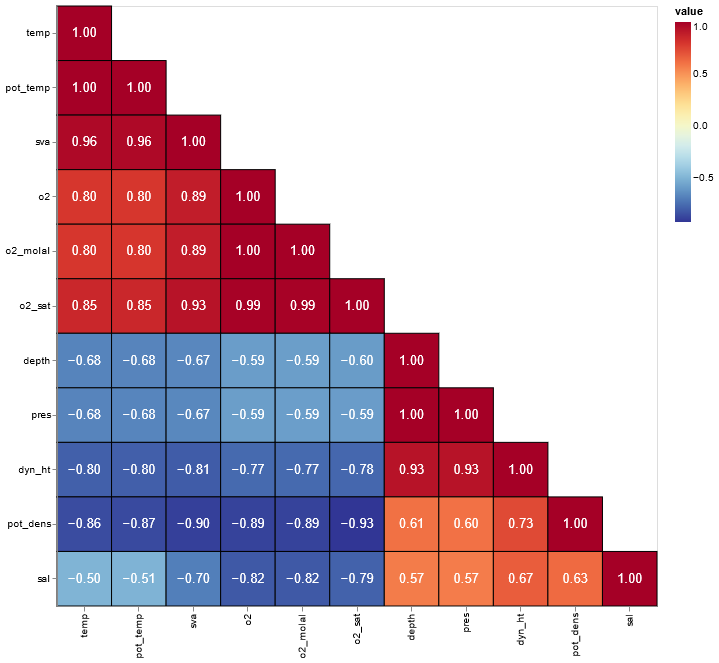

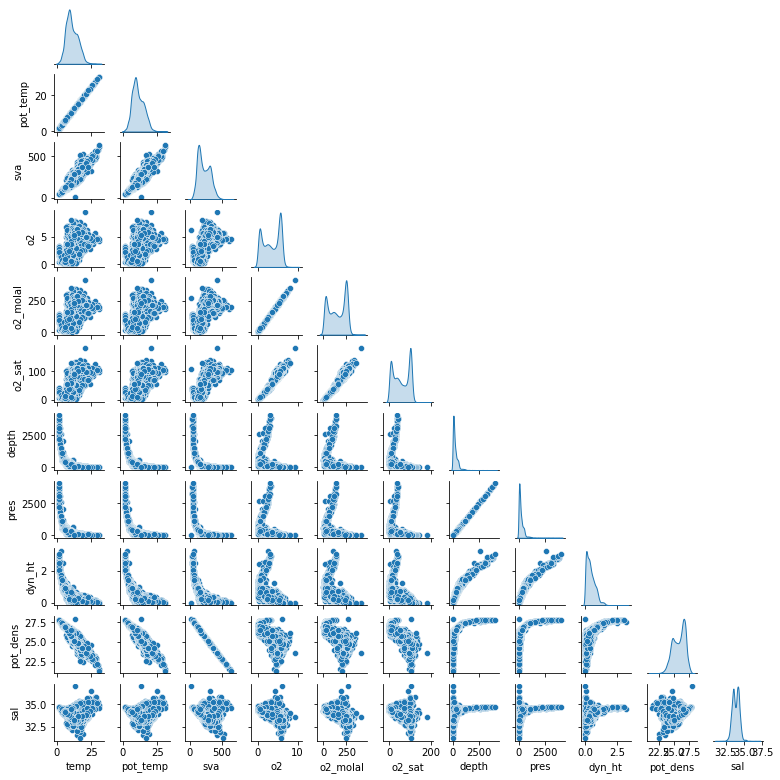

In [20]:
sns.pairplot(
    ft_slc_df.drop(columns='cruise').dropna().sample(10000),
    diag_kind='kde',
    height=1,
    corner=True)

the corr plots show that some columns are given by others,  
and if you drill down with formulae you'll find that it holds true mathematically as well.  
therefore they'll be forsaken.

In [21]:
ft_slc_df.drop(columns=['pot_temp', 'o2_molal',
               'o2_sat', 'pres', 'pot_dens'], inplace=True)

In [22]:
# quick_test(ft_slc_df)

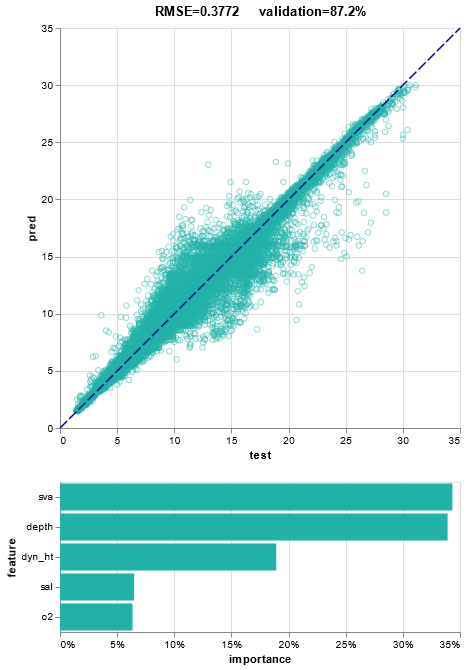

In [23]:
df = ft_slc_df.copy()

### null handling

the method for null filling will be to group the data by depths and filling the nulls using the mean for each group. one thing to notice is the distribution for depths which is exponentially decaying.

In [24]:
fillna_df = df.copy()

In [25]:
fillna_df['depth_bins'] = fillna_df['depth'].astype(int)

In [26]:
# pl1 = plot_histogram(fillna_df, 'depth_bins')
# pl2 = plot_histogram(fillna_df[fillna_df.depth_bins<1200], 'depth_bins')
# pl3 = plot_histogram(fillna_df[fillna_df.depth_bins<600], 'depth_bins')
# pl4 = plot_histogram(fillna_df[fillna_df.depth_bins<300], 'depth_bins')

# (pl1 | pl2) & (pl3 | pl4)

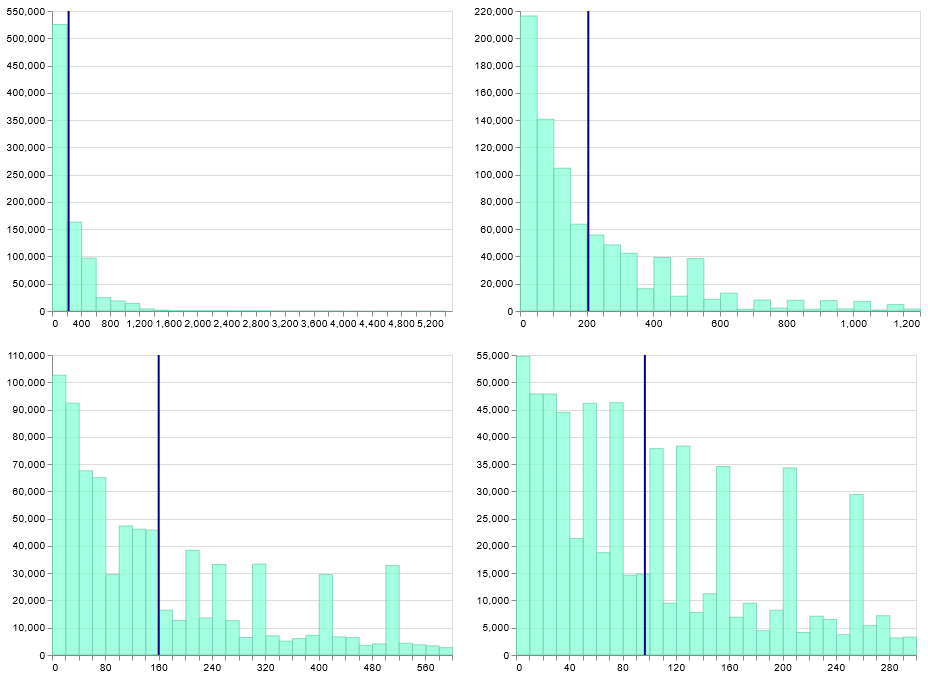

In [27]:
def bin_column(col, min_lim, bin_range):
    binned_col = col.where(col<min_lim, col.apply(
            lambda num: bin_range*round(num/bin_range)))
    return binned_col

In [28]:
mins = [0,100,300,600]
bins = [5,10,20,50]

for i in range(4):
    fillna_df['depth_bins'] = bin_column(fillna_df['depth_bins'], mins[i], bins[i])

fillna_df.loc[fillna_df['depth_bins']>1200, 'depth_bins'] = 1200

fillna_df['depth_bins'].value_counts()

10      46498
0       46062
120     43669
30      42418
50      40399
        ...  
650      1367
950      1205
1150     1008
850       976
1050      657
Name: depth_bins, Length: 68, dtype: int64

In [29]:
print('nulls pre cleanup:', fillna_df.isnull().any(axis=1).sum())

nully_cols = fillna_df.columns[fillna_df.isnull().sum().astype(bool)]

for col in nully_cols:
    print(f'filling {fillna_df[col].isnull().sum()} nulls in {col}')
    
    fillna_df[col].fillna(fillna_df.groupby(
        ['depth_bins'])[col].transform('mean'), inplace=True)
    
print('nulls post cleanup:', fillna_df.isnull().any(axis=1).sum())

fillna_df.drop(columns='depth_bins', inplace=True)

nulls pre cleanup: 197783
filling 41808 nulls in sva
filling 162613 nulls in o2
filling 39264 nulls in dyn_ht
filling 39653 nulls in sal
nulls post cleanup: 0


In [30]:
# quick_test(fillna_df)

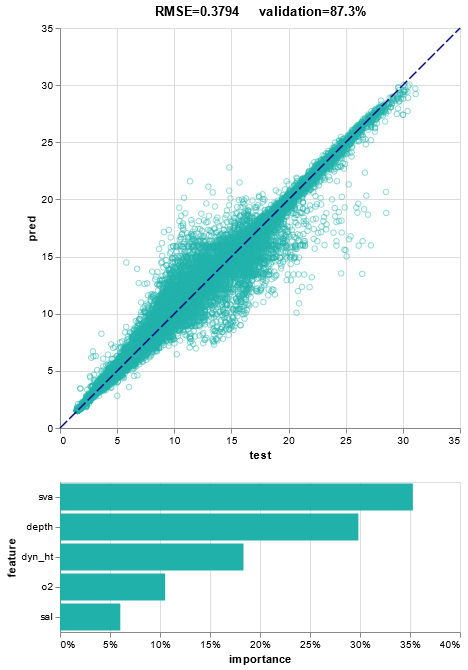

*wait, what happened here?*

if you go back to the pairplot in 2.1, you'll see that most columns are distributed unevenly. filling nulls in a more accurate way causes the uneven distributions to interfere even more with the measurements, which then causes the accuracy to worsen. however, sacrificing accuracy over correctness is the way to go. 

In [31]:
df = fillna_df.copy()

### enrichment

in addition to the oceanographic data, there is also a dataset concerning the cruises that included the measurements.  
out of that set only geographic (lat, lon, dist. from shore) and temporal (day\night and season) will be used. 

#### uploading and merging

In [32]:
cruise_data = pd.read_csv(
    '/'.join(['https:/',
              'raw.githubusercontent.com',
              'Morshay',
              'hot-cali-oceans',
              'master',
              'data',
              'cruise_data.csv']),
    usecols=['Cst_Cnt', 'Distance', 'Lat_Dec', 'Lon_Dec', 'Quarter', 'Time'],
    parse_dates=['Time']
).rename(str.lower, axis='columns')
cruise_data.time = cruise_data.time.dropna().dt.hour
print(cruise_data.info())
cruise_data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34404 entries, 0 to 34403
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cst_cnt   34404 non-null  int64  
 1   quarter   34404 non-null  int64  
 2   distance  19714 non-null  float64
 3   time      34080 non-null  float64
 4   lat_dec   34404 non-null  float64
 5   lon_dec   34404 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.6 MB
None


,cst_cnt,quarter,distance,time,lat_dec,lon_dec
29423,29424,2,-208.590,6.0,31.756666,-121.315000
13099,13100,1,-272.630,NaN,33.883333,-126.500000
19643,19644,1,-209.230,11.0,31.750000,-121.325000
6384,6385,4,NaN,5.0,30.333333,-116.383333
17037,17038,4,-44.060,11.0,37.616666,-123.616666
18961,18962,1,NaN,19.0,30.648333,-114.225000
32806,32807,4,-31.017,12.0,34.890000,-121.200000
23567,23568,3,-83.230,18.0,33.578333,-120.755000
19894,19895,2,-151.420,7.0,32.658333,-121.050000
2114,2115,4,NaN,10.0,20.850000,-112.500000


In [33]:
merged_df = df.copy().merge(
    cruise_data,
    how='left',
    left_on='cruise',
    right_on='cst_cnt'
).drop(columns=['cst_cnt', 'cruise'])
merged_df

,temp,sva,o2,depth,dyn_ht,sal,quarter,distance,time,lat_dec,lon_dec
0,10.50,233.0,5.724800,0.0,0.000,33.440,1,NaN,9.0,38.833333,-124.083333
1,10.46,232.5,5.698096,8.0,0.010,33.440,1,NaN,9.0,38.833333,-124.083333
2,10.46,232.8,5.698096,10.0,0.020,33.437,1,NaN,9.0,38.833333,-124.083333
3,10.45,234.1,5.639270,19.0,0.040,33.420,1,NaN,9.0,38.833333,-124.083333
4,10.45,234.0,5.639270,20.0,0.040,33.421,1,NaN,9.0,38.833333,-124.083333
...,...,...,...,...,...,...,...,...,...,...,...
853895,18.74,402.4,5.810000,0.0,0.000,33.408,4,-1.558,22.0,32.953770,-117.279770
853896,18.74,402.5,5.810000,2.0,0.008,33.408,4,-1.558,22.0,32.953770,-117.279770
853897,18.69,400.8,5.800000,5.0,0.020,33.415,4,-1.558,22.0,32.953770,-117.279770
853898,18.16,389.1,5.820000,10.0,0.040,33.406,4,-1.558,22.0,32.953770,-117.279770


#### null filling

In [34]:
merged_df['rnd_dp'] = (10*round(merged_df.depth/10))

merged_df['rnd_dp'] = merged_df['rnd_dp'].where(
merged_df['rnd_dp']<100, merged_df['rnd_dp'].apply(
    lambda num: 50*round(num/50)))

merged_df.loc[merged_df['rnd_dp']>500, 'rnd_dp'] = 500

merged_df['rnd_dp'].value_counts()

500.0    120587
100.0     92164
150.0     67937
200.0     58887
250.0     53102
0.0       48679
10.0      48556
20.0      46992
300.0     45994
30.0      45861
50.0      45263
80.0      44289
400.0     41928
60.0      20215
40.0      19902
70.0      17636
450.0     14419
350.0     10984
90.0      10505
Name: rnd_dp, dtype: int64

In [35]:
print('nulls pre cleanup:', merged_df.isnull().any(axis=1).sum())
nully_cols = merged_df.columns[merged_df.isnull().sum().astype(bool)]

for col in nully_cols:
    print(f'filling {merged_df[col].isnull().sum()} nulls in {col}')
    
    merged_df[col].fillna(merged_df.groupby(
        ['rnd_dp'])[col].transform('mean'), inplace=True)
    # mode doesn't work with transform, sadly

print('nulls post cleanup:', merged_df.isnull().any(axis=1).sum())
merged_df.drop(columns='rnd_dp', inplace=True)

nulls pre cleanup: 353798
filling 348552 nulls in distance
filling 9893 nulls in time
nulls post cleanup: 0


In [36]:
merged_df.time = merged_df.time.astype(int)
merged_df.loc[(merged_df.time < 6) | (merged_df.time >= 18), 'time'] = 0 #night
merged_df.loc[(merged_df.time >= 6) & (merged_df.time < 18), 'time'] = 1 #day

#### testing

In [37]:
geo_cols = pd.Index(['distance', 'lat_dec', 'lon_dec'])
time_cols = pd.Index(['time', 'quarter'])
added_cols = pd.Index(['time', 'quarter', 'distance', 'lat_dec', 'lon_dec'])

In [38]:
# time_cols_test = alt.hconcat(*[quick_test(merged_df.drop(
#     columns=added_cols.drop(col)))
#     for col in time_cols])
  
# geo_cols_test = alt.hconcat(*[quick_test(merged_df.drop(
#     columns=added_cols.drop(col)))
#     for col in geo_cols])
    
# time_cols_test & geo_cols_test

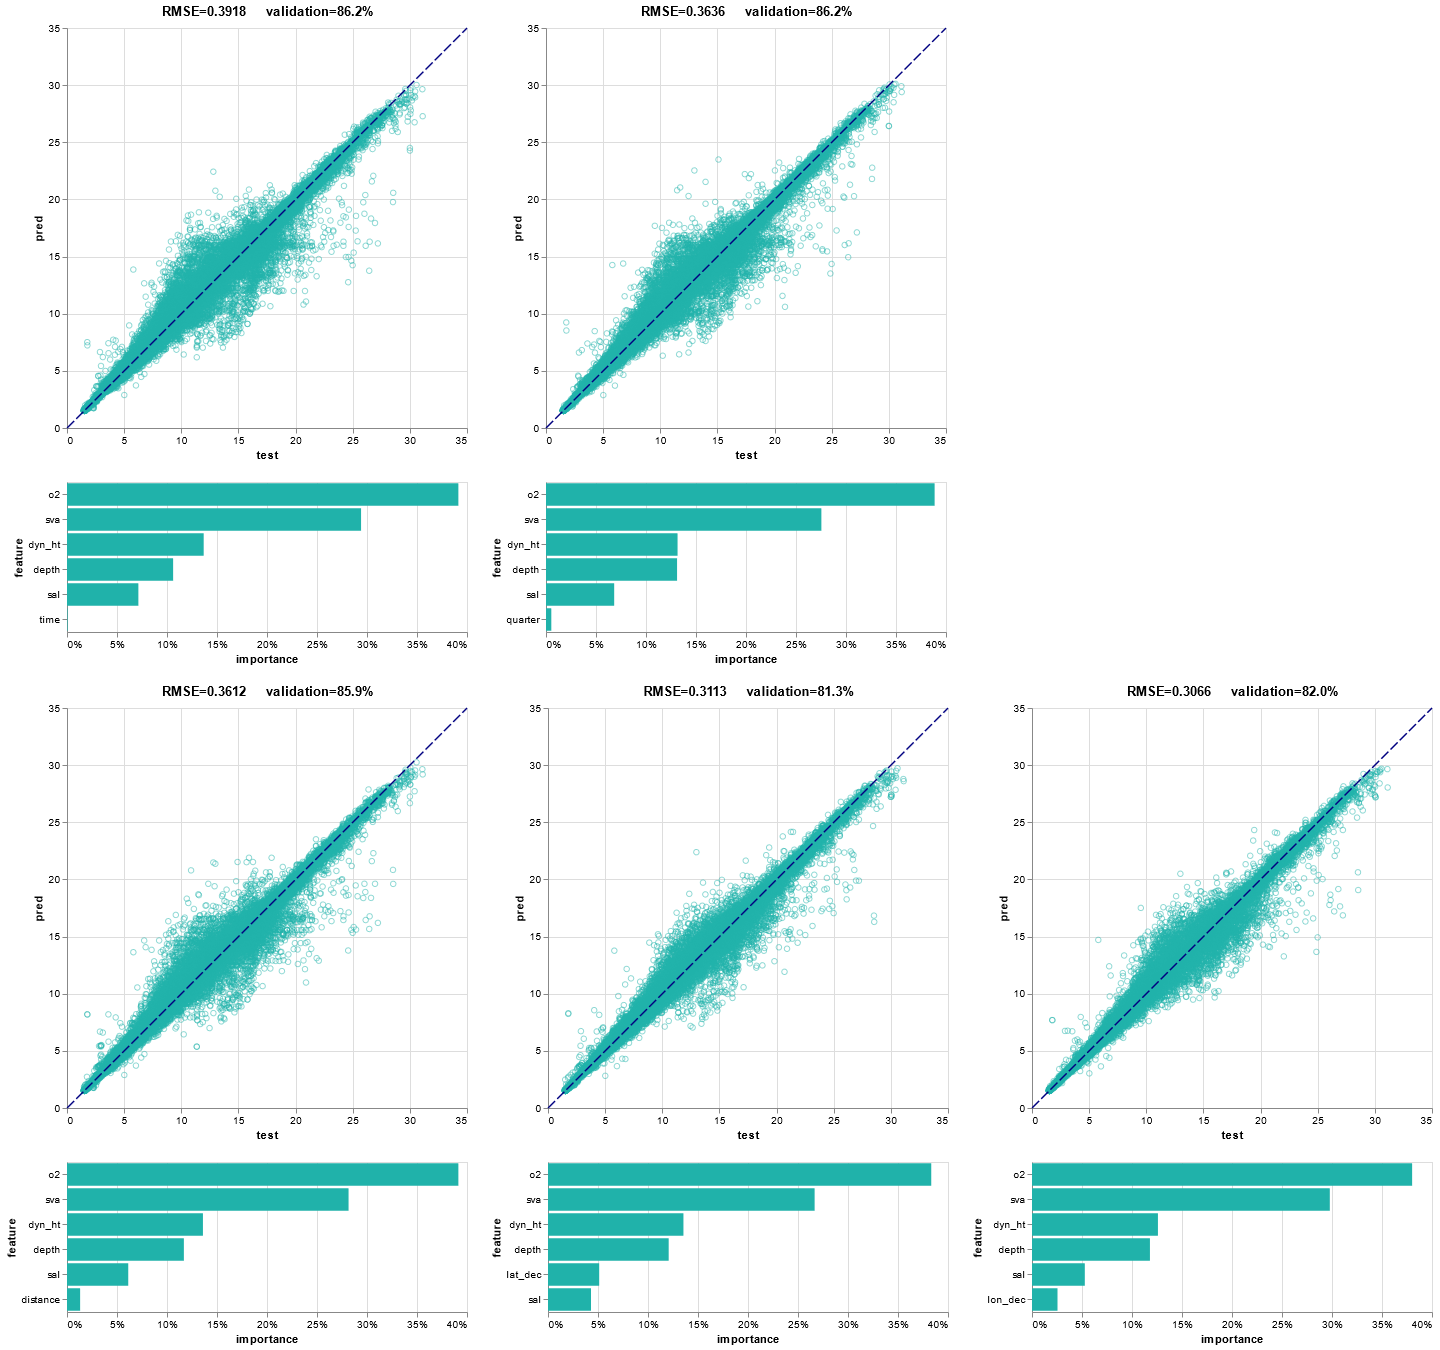

In [39]:
# time_test = quick_test(merged_df.drop(columns=geo_cols))
# geo_test = quick_test(merged_df.drop(columns=time_cols))
# time_test | geo_test

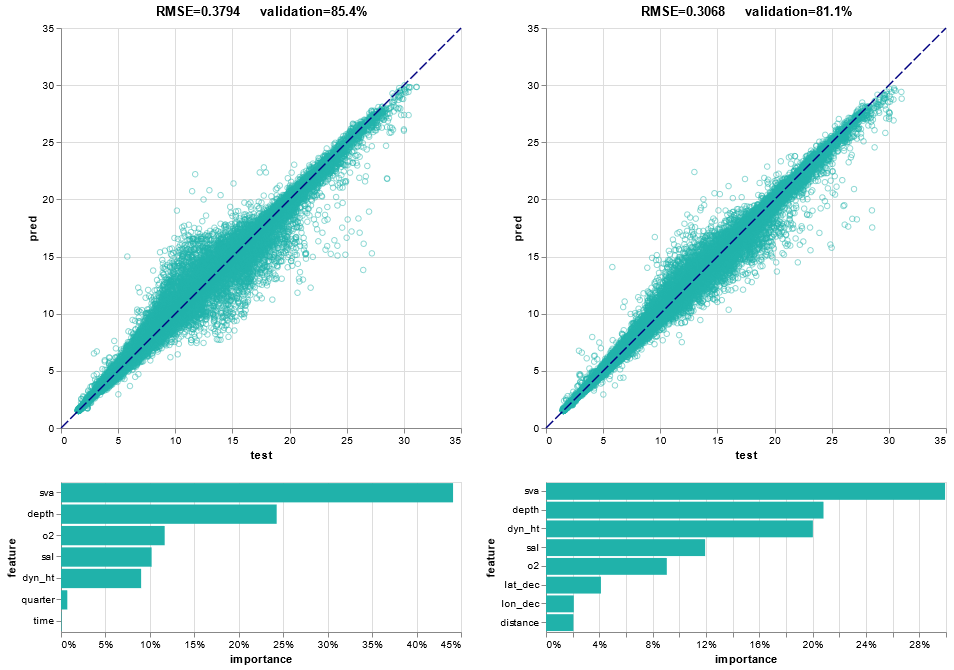

In [40]:
# quick_test(merged_df)

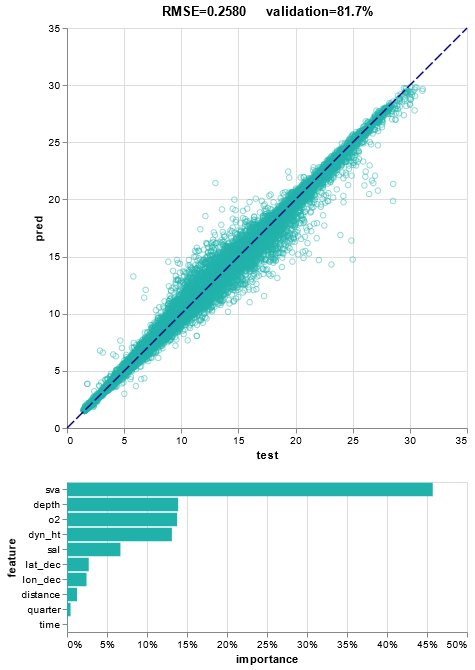

In [41]:
df = merged_df.copy()

### outlier removal

In [42]:
outlier_df = df.copy()

In [43]:
def remove_outliers(data, lower_limit, upper_limit):
    
    outlier_cols = data.select_dtypes(
        include=['float']).columns.drop('temp')
    
    for col in outlier_cols:
        cond = data[col].between(
            lower_limit[col], upper_limit[col])
        
        outliers = len(data[~cond])
        data = data[cond]
        
        print(f'{outliers} outliers removed from {col}')
    
    print(f'\ntotal rows post removal: {len(data)}')
    return data

two methods of removal will be tested - 10σ and iqr.

In [44]:
ten_sigma_df = remove_outliers(outlier_df.copy(),
    outlier_df.mean()-5*outlier_df.std(),
    outlier_df.mean()+5*outlier_df.std())

0 outliers removed from sva
0 outliers removed from o2
4856 outliers removed from depth
6 outliers removed from dyn_ht
132 outliers removed from sal
3219 outliers removed from distance
0 outliers removed from lat_dec
2087 outliers removed from lon_dec

total rows post removal: 843600


In [45]:
iqr_df = remove_outliers(outlier_df.copy(),
    0.5*(5*outlier_df.quantile(0.25)-3*outlier_df.quantile(0.75)),
    0.5*(5*outlier_df.quantile(0.75)-3*outlier_df.quantile(0.25)))

583 outliers removed from sva
0 outliers removed from o2
54590 outliers removed from depth
12 outliers removed from dyn_ht
2461 outliers removed from sal
58799 outliers removed from distance
32647 outliers removed from lat_dec
6976 outliers removed from lon_dec

total rows post removal: 697832


In [46]:
# quick_test(ten_sigma_df) | quick_test(iqr_df)

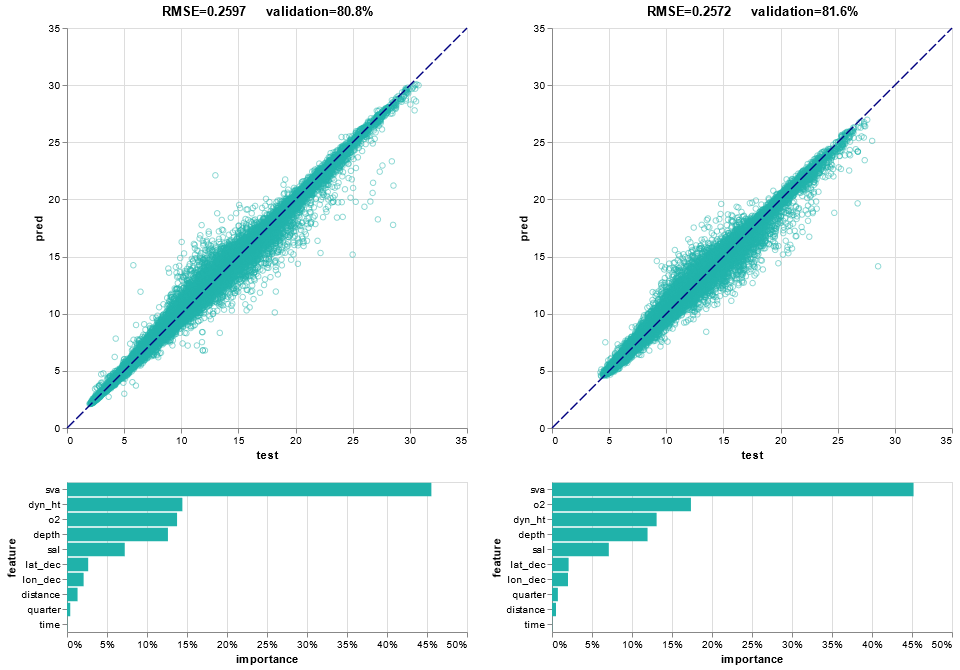

comparing combinations of both

In [47]:
sig_to_iqr_df = remove_outliers(ten_sigma_df.copy(),
    0.5*(5*ten_sigma_df.quantile(0.25)-3*ten_sigma_df.quantile(0.75)),
    0.5*(5*ten_sigma_df.quantile(0.75)-3*ten_sigma_df.quantile(0.25)))

571 outliers removed from sva
0 outliers removed from o2
48712 outliers removed from depth
6 outliers removed from dyn_ht
2374 outliers removed from sal
55982 outliers removed from distance
32997 outliers removed from lat_dec
6212 outliers removed from lon_dec

total rows post removal: 696746


In [48]:
iqr_to_sig_df = remove_outliers(iqr_df.copy(),
    iqr_df.mean()-5*iqr_df.std(),
    iqr_df.mean()+5*iqr_df.std())

0 outliers removed from sva
0 outliers removed from o2
0 outliers removed from depth
0 outliers removed from dyn_ht
0 outliers removed from sal
0 outliers removed from distance
0 outliers removed from lat_dec
0 outliers removed from lon_dec

total rows post removal: 697832


In [49]:
# quick_test(sig_to_iqr_df) | quick_test(iqr_to_sig_df)

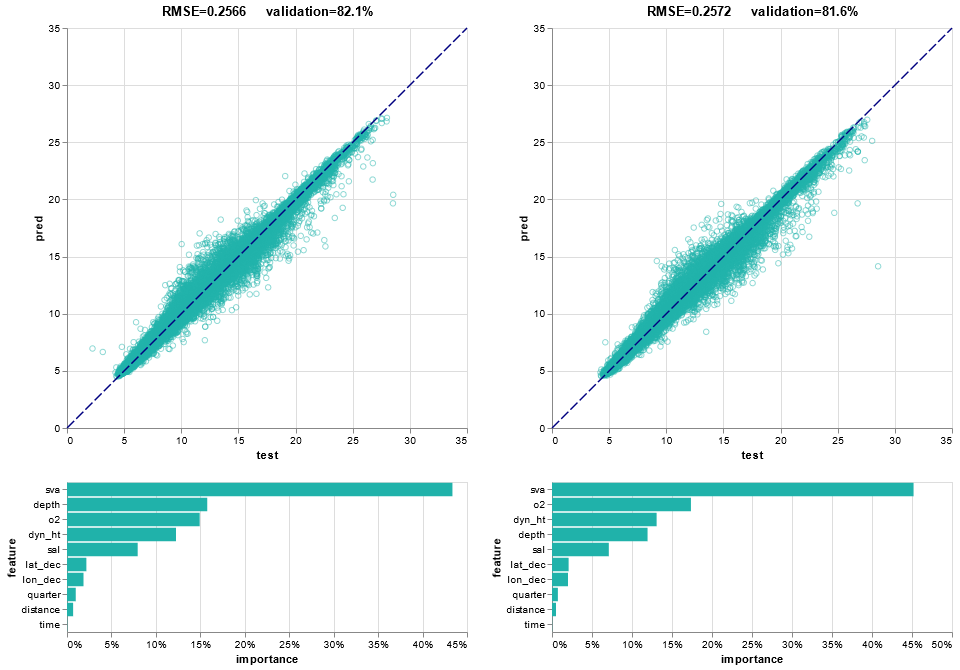

looks like the iqr method drops temperatures below 5°C and 10σ doesn't improve anything.  
therefore no outliers will be removed from the data.

## model optimization

In [50]:
final_df = df.copy()

In [51]:
def calc_params(param, calc_range):

    res = []
    for num in calc_range:
        
        print(f'calculating {param}={round(num,2)}:[', end='')
        for run in range(20):
            print('|', end='')

            X_train, X_test, y_train, y_test = split_data(
                final_df, seeded=False,
                tst_pct=(.3, num)[param == 'test_size'])

            m = plant_forest(
                X_train, y_train, seeded=False,
                num_of_trees=(10, num)[param == 'n_estimators'],
                smp_per_tree=(.25, num)[param == 'max_samples'])

            y_test_pred = m.predict(X_test)
            rmse_test = rmse(y_test, y_test_pred)

            y_train_pred = m.predict(X_train)
            valid = rmse(y_train, y_train_pred)/rmse_test   
            
            res.append([round(num,2), rmse_test, valid])
        print('] done!')
    print('calculation completed!\n\n')
    res_df = pd.DataFrame(res, columns=[param, 'RMSE', 'validation'])

    return res_df

In [52]:
def plot_measure(base, measure, clr):

    line = base.mark_line(strokeWidth=1).encode(
        y=alt.Y(f'mean({measure}):Q', scale=alt.Scale(zero=False)))

    band = base.mark_errorband(extent='ci').encode(
        y=alt.Y(f'{measure}:Q', axis=alt.Axis(titleColor=clr)))

    plot = (line+band).encode(color=alt.value(clr))

    return plot

In [53]:
def plot_params(param):

    chart = alt.Chart(opt_data[param]).encode(x=f'{param}:Q')
    
    opt_plot = alt.layer(
        plot_measure(chart, 'RMSE', 'forestgreen'),  # a random forest!
        plot_measure(chart, 'validation', 'burlywood')  # wood from a decision tree!
    ).resolve_scale(y='independent').properties(height=200, width=600)

    return opt_plot

In [54]:
# params = 'test_size n_estimators max_samples'.split(' ')

# opt_ranges = {'test_size': np.arange(0.05, 0.51, 0.05),
#               'n_estimators': np.arange(50, 121, 10),
#               'max_samples': np.arange(0.1, 0.31, 0.05)}

# opt_data = {param: calc_params(param, opt_ranges[param]) for param in params}
# alt.vconcat(*[plot_params(param) for param in params])

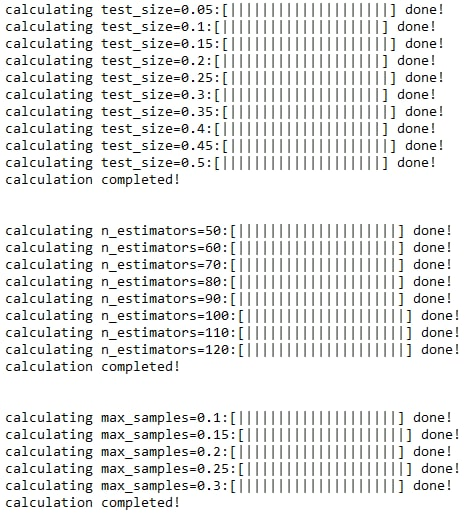

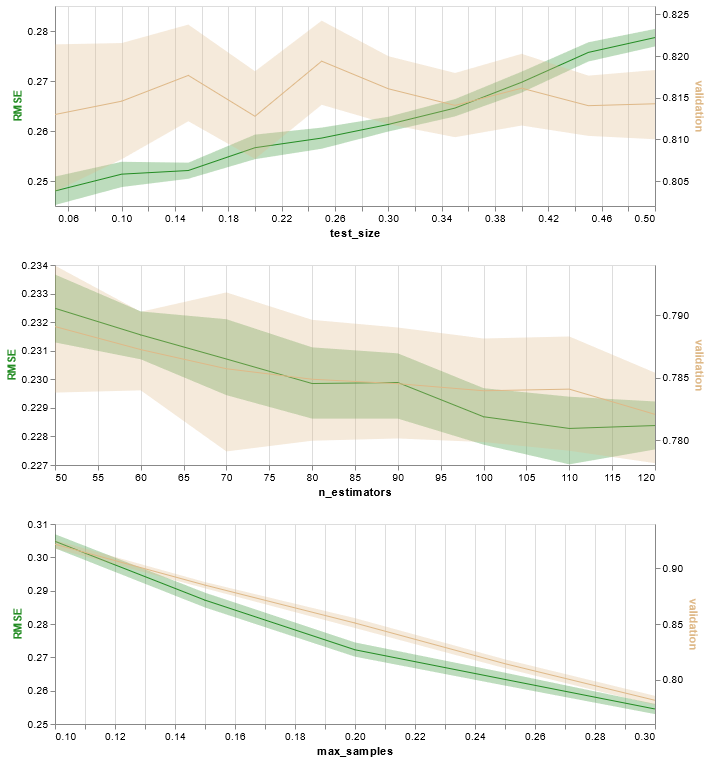

the picture is not as clear here, sadly.  
keeping the RMSE below 0.3 and the validation score above 80% is the goal, but it's not as easy as it seems.

- test size:  
rmse is below 0.3 regardless of choice, and the highest validation score is for 0.25. however, 0.15 gives a lower rmse and is really close to the highest validation score, and so **the final choice is 0.15.**


- number of trees:
validation score is lower than 80% either way, but is above 78% which is not that bad. the RMSE has a steep curve almost all the way, and above 100 it turns shallow. therefore **the final choice is 100.**


- max samples:
both rmse and validation score go down monotonicly. validation score even dips below 80% near the end. rmse has the steepest curve up until 0.2, and the validation score there is around 85%, which is pretty good. **the final choice is 0.2.**

## bottom line

### final test

In [55]:
X_train, X_test, y_train, y_test = split_data(df, tst_pct=.15)
model = plant_forest(X_train, y_train, num_of_trees=100, smp_per_tree=.2)
# plot_forest_results(model, X_train, X_test, y_train, y_test)

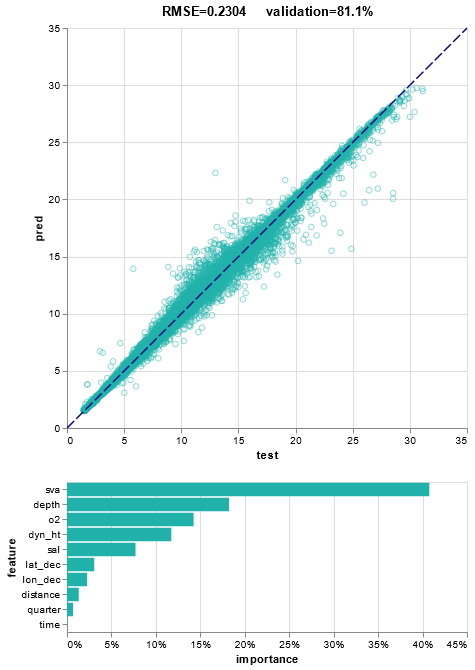

as it stands, after feature engineering and model optimization,  
the result is lowest RMSE score (5.4% of the naive model) and a validation above 80%!

### residual

in addition to the scatter, it is necessary to show the residual score, or in other words - **the error for each prediction.**

<AxesSubplot:xlabel='temp_range', ylabel='residual'>

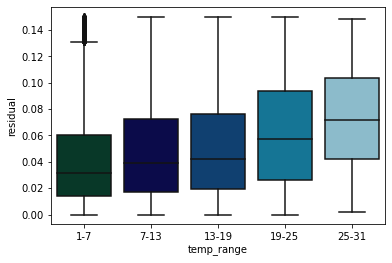

In [56]:
bins = list(range(1, 32, 6))
labels = [f'{bins[i]}-{bins[i+1]}'
          for i in range(len(bins)-1)]

temps_binned = pd.cut(
    y_test,
    bins=bins,
    labels=labels)

resid = np.abs(model.predict(X_test)-y_test)

resid_df = pd.DataFrame(
    data={'temp_range': temps_binned,
          'residual': resid})

trimmed_resid = resid_df[resid_df.residual < .15]

sns.boxplot(
    x=trimmed_resid.temp_range,
    y=trimmed_resid.residual,
    palette='ocean' # ocean, get it?
)

the higher the temperatures are, the larger the error is, but by a tiny margin. overall the residuals are small.

## addendum - linear regression

In [57]:
def lm_test(data, col='temp', print_eq=False):

    try:
        data = data.drop(columns='cruise')
    except KeyError:
        pass

    X_train, X_test, y_train, y_test = split_data(data, col)

    print('\nregressing linearly...')
    lm = LinearRegression().fit(X_train, y_train)

    y_test_pred = lm.predict(X_test)
    test_rmse = rmse(y_test, y_test_pred)

    y_train_pred = lm.predict(X_train)
    valid = rmse(y_train, y_train_pred)/test_rmse

    scatter = alt.Chart(
        pd.DataFrame(data={'test': y_test, 'pred': y_test_pred}),
        title= f'RMSE={test_rmse:.4f}     validation={valid:.1%}'
    ).mark_point(strokeWidth=1, opacity=0.5
                 ).encode(x='test:Q', y='pred:Q',
                          color=alt.value('lightseagreen')
                          ).properties(height=300, width=300)

    trendline = alt.Chart(
        pd.DataFrame({'test': [0, 35], 'pred': [0, 35]})
    ).mark_line(strokeDash=[10, 3], strokeWidth=1.5
                ).encode(x='test:Q', y='pred:Q',
                         color=alt.value('navy'))

    print(f'\nbenchmark stdev: {benchmark_stdev:.4f}\n')

    if print_eq:
        print('final regression equation:')
        print(f'{col}={lm.intercept_:.3f}'+''.join(
            [f'{lm.coef_[i]:+.3f}•{X_train.columns[i]}'
             for i in range(len(lm.coef_))]))
    
    return scatter+trendline

In [58]:
# lm_test(init_df) | lm_test(final_df, print_eq=True)

final regression equation:  
temp = -94.407 + 0.046•sva + 0.087•o2 - 0.000•depth - 1.521•dyn_ht + 2.916•sal  
        + 0.012•quarter - 0.000•distance - 0.004•time - 0.075•lat_dec + 0.005•lon_dec

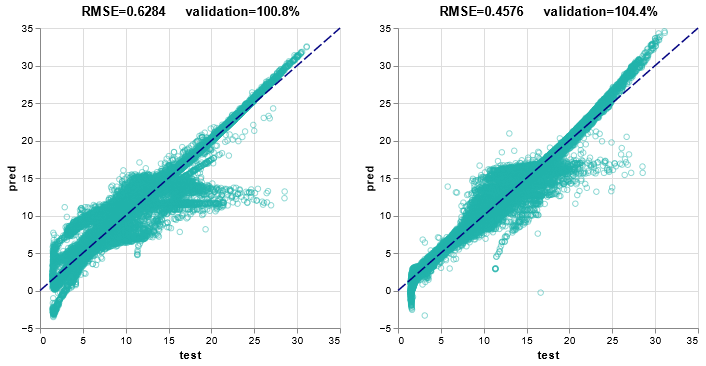

linear regression gives bad results, even though almost all the features are numerical.